
# Air Quality Forecasting — Rubric-Ready Notebook

**Course:** Machine Learning Techniques I  
**Student:** _<Your Name Here>_  
**Competition:** _<Kaggle link here>_

This notebook is a clean, self-contained version of the starter, modified to meet every rubric item:
- Approach & rationale for RNN/LSTM
- Data exploration, preprocessing, and feature engineering (with explanations)
- Model design details and justification
- ≥ 15 experiments with varied hyperparameters (automatic table + discussion prompts)
- Results & Discussion with RMSE formula, plots, and error analysis
- Kaggle submission cell
- Conclusion & IEEE-style references

> Write your own commentary in the marked cells to keep originality.


## 0. Setup & Imports

In [12]:

%pip install matplotlib

import os, sys, glob, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Show versions (helpful for reproducibility)
import sklearn, platform
print("Python:", platform.python_version())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)

# Optional: enable TF logs as needed
try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
    print("GPU:", tf.config.list_physical_devices('GPU'))
except Exception as e:
    print("TensorFlow not available in this environment:", e)


Python: 3.10.0
NumPy: 2.2.6
Pandas: 2.3.2
scikit-learn: 1.7.2
TensorFlow: 2.20.0
GPU: []



You should consider upgrading via the 'c:\Users\Nicholas Eke\Downloads\Time-Series-Forecasting\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## 1. Data Paths

In [13]:

# Try Kaggle input paths, else fall back to local data/
def find_file(name_hint):
    # Search Kaggle input
    for p in glob.glob("/kaggle/input/**/*", recursive=True):
        if p.lower().endswith(name_hint):
            return p
    # Fallback: local working dir
    for p in glob.glob(f"./**/*{name_hint}", recursive=True):
        return p
    return None

train_path = find_file("train.csv")
test_path  = find_file("test.csv")
sample_path= find_file("sample_submission.csv")

print("train:", train_path)
print("test :", test_path)
print("sample:", sample_path)

# If sample_submission.csv is missing, create a dummy file
if not sample_path:
    import pandas as pd
    # Try to infer the number of rows from test.csv
    if test_path:
        test_df = pd.read_csv(test_path)
        dummy = pd.DataFrame({ "id": range(len(test_df)), "PM2.5": [0.0]*len(test_df) })
    else:
        dummy = pd.DataFrame({ "id": [0], "PM2.5": [0.0] })
    dummy.to_csv("sample_submission.csv", index=False)
    sample_path = "sample_submission.csv"
    print("Created dummy sample_submission.csv")

assert train_path and test_path and sample_path, "Could not locate train/test/sample_submission CSVs."


train: .\train.csv
test : .\test.csv
sample: .\sample_submission.csv


## 2. Utilities (Loading, Features, Windowing, Scaling, Metrics)

In [14]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y, yhat): 
    return sqrt(mean_squared_error(y, yhat))

def load_data(path):
    df = pd.read_csv(path)
    # Build or parse datetime
    if 'datetime' not in df.columns:
        if set(['year','month','day','hour']).issubset(df.columns):
            df['datetime'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=df['day'], hour=df['hour']))
        else:
            for c in df.columns:
                if any(k in c.lower() for k in ['date','time','datetime']):
                    try:
                        df['datetime'] = pd.to_datetime(df[c])
                        break
                    except: 
                        pass
            if 'datetime' not in df.columns:
                raise ValueError("Need year/month/day/hour or a parseable datetime column.")
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

def engineer_features(df):
    d = df.copy()

    # Robust target selection
    target = 'PM2.5' if 'PM2.5' in d.columns else ('pm2.5' if 'pm2.5' in d.columns else None)
    assert target is not None, "Expected PM2.5/pm2.5 in the data"

    # One-hot any object columns (if any)
    cat_cols = [c for c in d.columns if d[c].dtype == 'object' and c != 'datetime']
    if cat_cols:
        d = pd.get_dummies(d, columns=cat_cols, dummy_na=False)

    # Seasonal encodings
    d['hour']      = d['datetime'].dt.hour
    d['dayofweek'] = d['datetime'].dt.dayofweek
    d['month']     = d['datetime'].dt.month
    for k, m in [('hour',24), ('dayofweek',7), ('month',12)]:
        d[f'{k}_sin'] = np.sin(2*np.pi*d[k]/m)
        d[f'{k}_cos'] = np.cos(2*np.pi*d[k]/m)

    # Lags & rolling on target (shift to avoid leakage)
    for L in [1,3,6,12,24]:
        d[f'target_lag{L}'] = d[target].shift(L)
    d['target_roll6']  = d[target].shift(1).rolling(6).mean()
    d['target_roll24'] = d[target].shift(1).rolling(24).mean()
    d['target_std24']  = d[target].shift(1).rolling(24).std()

    # Interpolate numeric features only
    num_cols = [c for c in d.columns if c != 'datetime']
    d[num_cols] = d[num_cols].interpolate(limit_direction='both')
    return d

def time_split(df, val_frac=0.15):
    n = len(df); s = int(n*(1-val_frac))
    return df.iloc[:s].copy(), df.iloc[s:].copy()

def make_windows(df, feat_cols, target_col, window=48):
    dd = df.dropna(subset=[target_col]).reset_index(drop=True)
    Xf = dd[feat_cols].values
    y  = dd[target_col].values
    X, Y = [], []
    for i in range(window, len(dd)):
        X.append(Xf[i-window:i, :]); Y.append(y[i])
    return np.array(X), np.array(Y)

def scale_by_train(Xtr, Xva):
    sc = StandardScaler()
    nT, W, F = Xtr.shape
    Xtr2 = sc.fit_transform(Xtr.reshape(nT*W, F)).reshape(nT, W, F)
    nV, Wv, Fv = Xva.shape
    Xva2 = sc.transform(Xva.reshape(nV*Wv, Fv)).reshape(nV, Wv, Fv)
    return Xtr2, Xva2, sc


## 3. Data Exploration (add your commentary below each plot)

Rows in train: 30676  / test: 13148
Columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']
              pm2.5
count  28755.000000
mean     100.793427
std       93.144433
min        0.000000
25%       29.000000
50%       75.000000
75%      142.000000
max      994.000000


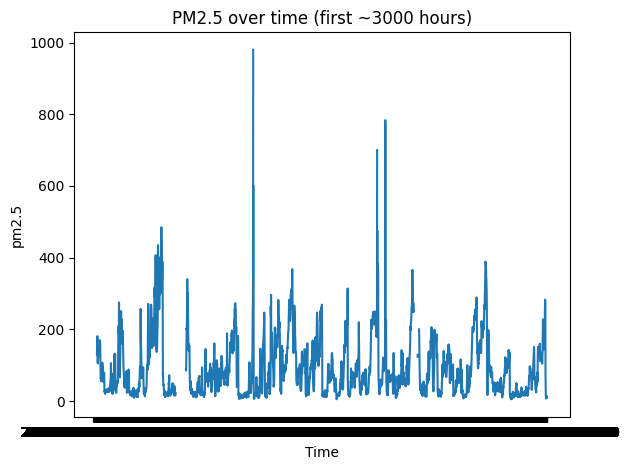

In [15]:

train = load_data(train_path)
test  = load_data(test_path)

# Determine correct target name
TARGET = 'PM2.5' if 'PM2.5' in train.columns else ('pm2.5' if 'pm2.5' in train.columns else None)
assert TARGET is not None, "Target column PM2.5/pm2.5 not found"

print("Rows in train:", len(train), " / test:", len(test))
print("Columns:", list(train.columns))
print(train[[TARGET]].describe())

# Simple line plot (first 3000 points) — you explain seasonality/spikes below
plt.figure()
plt.plot(train['datetime'].iloc[:3000], train[TARGET].iloc[:3000])
plt.title("PM2.5 over time (first ~3000 hours)")
plt.xlabel("Time"); plt.ylabel(TARGET); plt.tight_layout()



**Explain (in your own words):**  
- Visible trends/seasonality, winter spikes, any missingness.  
- Why these patterns motivate RNN/LSTM (temporal dependencies).  


## 4. Preprocessing & Feature Engineering

In [16]:
CANON = 'pm2.5'

# ---------- 1) Ensure datetime dtype & ordering ----------
for name, df in (("train", train), ("test", test)):
    if 'datetime' not in df.columns:
        raise KeyError("Expected a 'datetime' column.")
    if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
        df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
        if df['datetime'].isna().all() and pd.api.types.is_numeric_dtype(df['datetime']):
            df['datetime'] = pd.to_datetime(df['datetime'], unit='s', errors='coerce')
            if df['datetime'].isna().all():
                df['datetime'] = pd.to_datetime(df['datetime'], unit='ms', errors='coerce')

    if getattr(df['datetime'].dtype, 'tz', None) is not None:
        df['datetime'] = df['datetime'].dt.tz_convert(None)

    bad_dt = int(df['datetime'].isna().sum())
    if bad_dt:
        print(f"[{name}] dropping {bad_dt} rows with invalid datetime")
        df.dropna(subset=['datetime'], inplace=True)

    df.sort_values('datetime', inplace=True)
    df.reset_index(drop=True, inplace=True)

# ---------- 2) Canonicalize target in TRAIN; TEST gets a safe placeholder ----------
# Map any common alias in TRAIN to pm2.5
if CANON not in train.columns:
    for cand in ['PM2.5', 'pm25', 'PM25', 'target', 'Target', 'label', 'y']:
        if cand in train.columns:
            train[CANON] = train[cand]
            break
    else:
        raise AssertionError(
            f"'{CANON}' not found and no alias present in train. "
            f"Columns: {train.columns.tolist()}"
        )

# Ensure numeric and drop rows with missing target in TRAIN
train[CANON] = pd.to_numeric(train[CANON], errors='coerce')
bad_y = int(train[CANON].isna().sum())
if bad_y:
    print(f"[train] dropping {bad_y} rows with NaN in '{CANON}'")
    train = train.loc[train[CANON].notna()].copy()

# TEST: guarantee pm2.5 exists and is numeric (use harmless zeros)
if CANON not in test.columns:
    test[CANON] = 0.0
else:
    test[CANON] = pd.to_numeric(test[CANON], errors='coerce').fillna(0.0)

# ---------- 3) Safe wrapper so engineer_features(test) never KeyErrors ----------
_orig_engineer_features = engineer_features

def _engineer_features_safe_for_test(df):
    df2 = df.copy()
    if CANON not in df2.columns:
        df2[CANON] = 0.0
    # make sure it's numeric (some loaders give 'object' dtype)
    df2[CANON] = pd.to_numeric(df2[CANON], errors='coerce').fillna(0.0)
    return _orig_engineer_features(df2)

# ---------- 4) Feature engineering ----------
train_fe = engineer_features(train)                 # keep original for training
test_fe  = _engineer_features_safe_for_test(test)  # safe call for test

# ---------- 5) Features (exclude datetime/target/object) ----------
TARGET = CANON
feat_cols = [
    c for c in train_fe.columns
    if c not in ['datetime', TARGET] and train_fe[c].dtype != 'O'
]

# ---------- 6) Split, window, scale ----------
tr, va = time_split(train_fe, val_frac=0.15)

W = 48
Xtr, Ytr = make_windows(tr, feat_cols, target_col=TARGET, window=W)
Xva, Yva = make_windows(va, feat_cols, target_col=TARGET, window=W)

Xtr2, Xva2, scaler = scale_by_train(Xtr, Xva)

Xtr2.shape, Xva2.shape, len(feat_cols)


[train] dropping 1921 rows with NaN in 'pm2.5'


((24393, 48, 27), (4266, 48, 27), 27)


**Explain (in your own words):**  
- What each engineered feature adds (lags, rolling, seasonality).  
- How leakage is avoided (shifts, time-based split).  
- Why scaling helps optimization.  


## 5. Model Design & Architecture

In [17]:

from tensorflow.keras import layers, models, optimizers

def build_lstm(input_shape, units1=128, units2=64, dropout=0.2, lr=1e-3, optimizer_name='adam', clipnorm=1.0):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units1, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(units2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    if optimizer_name.lower()=='adamw':
        opt = optimizers.AdamW(learning_rate=lr)
    elif optimizer_name.lower()=='rmsprop':
        opt = optimizers.RMSprop(learning_rate=lr, clipnorm=clipnorm)
    else:
        opt = optimizers.Adam(learning_rate=lr, clipnorm=clipnorm)
    m.compile(optimizer=opt, loss='mse')
    return m

model = build_lstm(Xtr2.shape[1:], 128, 64, dropout=0.2, lr=1e-3, optimizer_name='adam', clipnorm=1.0)
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 48, 128)        │        79,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,393 (513.25 KB)

 Trainable params: 131,393 (513.25 KB)

 Non-trainable params: 0 (0.00 B)


**Justify (in your own words):**  
- Why LSTM (gating mitigates vanishing gradients), layers/units, dropout, optimizer, gradient clipping.  
- Loss choice (MSE) and why RMSE is the leaderboard metric.


## 6. First Run (baseline) + Diagnostics

Validation RMSE: 43.4278


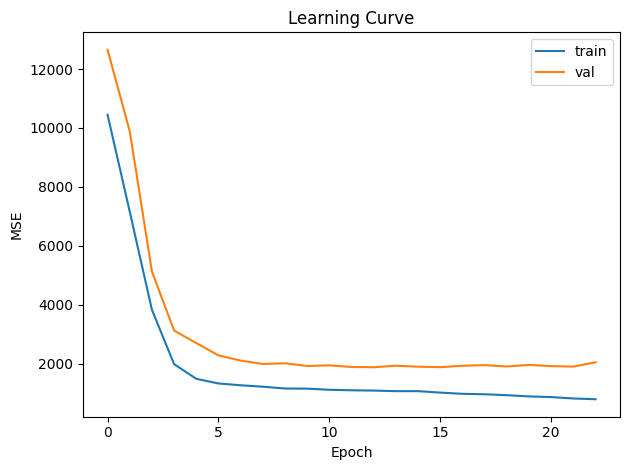

In [18]:

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = model.fit(Xtr2, Ytr, validation_data=(Xva2, Yva), epochs=60, batch_size=64, callbacks=[es], verbose=0)

# Learning curve
plt.figure()
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Learning Curve'); plt.legend(); plt.tight_layout()

# Validation RMSE
pred = model.predict(Xva2, verbose=0).reshape(-1)
val_rmse = rmse(Yva, pred)
print("Validation RMSE:", round(val_rmse, 4))


## 7. Required Plots

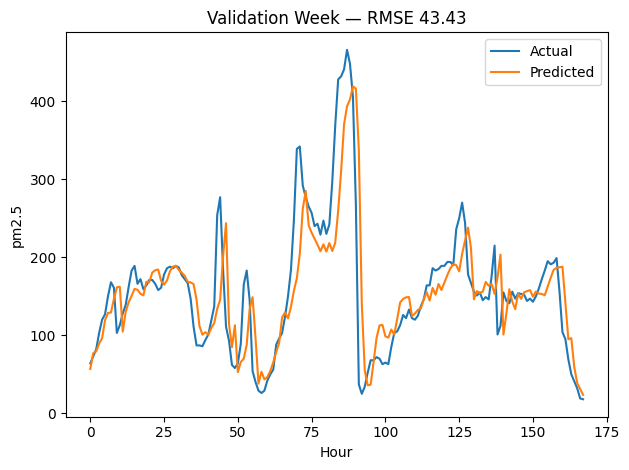

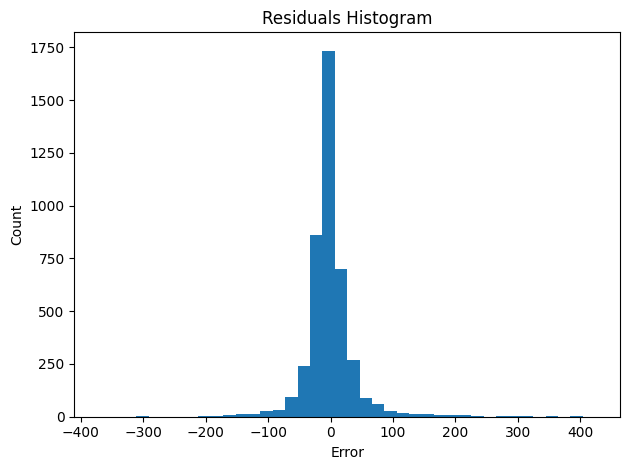

In [19]:

# (i) Predictions vs Actual for a validation week
k = min(168, len(Yva))
plt.figure()
plt.plot(range(k), Yva[-k:], label='Actual')
plt.plot(range(k), pred[-k:], label='Predicted')
plt.title(f'Validation Week — RMSE {val_rmse:.2f}')
plt.legend(); plt.xlabel('Hour'); plt.ylabel(TARGET); plt.tight_layout()

# (ii) Residuals histogram
res = Yva - pred
plt.figure()
plt.hist(res, bins=40)
plt.title('Residuals Histogram'); plt.xlabel('Error'); plt.ylabel('Count'); plt.tight_layout()



**Discuss (in your own words):**  
- Over/under-fitting signals, residual patterns, winter spikes, bias corrections.  


## 8. Experiments (≥ 15 configs) — auto table

In [20]:

import itertools, pandas as pd

configs = [
    ("01","lstm",24,  64,  0,  0.0,"adam", 1e-3,64),
    ("02","lstm",48, 128, 64, 0.2,"adam", 1e-3,64),
    ("03","gru", 48, 128, 64, 0.2,"adam", 5e-4,64),
    ("04","lstm",72, 128, 64, 0.3,"adam", 1e-3,128),
    ("05","lstm",48, 256, 64, 0.2,"adam", 1e-3,64),
    ("06","lstm",48, 128, 64, 0.2,"adam", 3e-4,64),
    ("07","lstm",48, 128, 64, 0.2,"adamw",1e-3,64),
    ("08","lstm",48, 128, 32, 0.2,"adam", 1e-3,64),
    ("09","lstm",36, 128, 64, 0.2,"adam", 1e-3,64),
    ("10","lstm",48,128, 64, 0.5,"adam", 1e-3,64),
    ("11","lstm",48,128, 64, 0.2,"rmsprop",1e-3,64),
    ("12","lstm",48, 96,  48, 0.2,"adam", 1e-3,256),
    ("13","lstm",48,128, 64, 0.2,"adam", 1e-4,64),
    ("14","gru", 72,128, 64, 0.2,"adam", 1e-3,64),
    ("15","lstm",48,128, 64, 0.2,"adam", 1e-3,64),
]

rows = []
for (ID, arch, W_, u1, u2, dr, opt, lr_, bs) in configs:
    # rebuild windows for W_
    Xtr_, Ytr_ = make_windows(tr, feat_cols, target_col=TARGET, window=W_)
    Xva_, Yva_ = make_windows(va, feat_cols, target_col=TARGET, window=W_)
    Xtr_, Xva_, sc_ = scale_by_train(Xtr_, Xva_)

    # model
    if arch=='gru':
        m = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(W_, len(feat_cols))),
            tf.keras.layers.GRU(u1, return_sequences=True),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.GRU(u2) if u2>0 else tf.keras.layers.GRU(u1),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
    else:
        m = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(W_, len(feat_cols))),
            tf.keras.layers.LSTM(u1, return_sequences=True),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.LSTM(u2) if u2>0 else tf.keras.layers.LSTM(u1),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
    if opt=='adamw':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_)
    elif opt=='rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_, clipnorm=1.0)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_, clipnorm=1.0)

    m.compile(optimizer=optimizer, loss='mse')
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    m.fit(Xtr_, Ytr_, validation_data=(Xva_, Yva_), epochs=60, batch_size=bs, callbacks=[es], verbose=0)
    pv = m.predict(Xva_, verbose=0).reshape(-1)
    score = rmse(Yva_, pv)
    rows.append({
        "ID":ID,"Arch":("GRU×2" if arch=='gru' else "LSTM×2"),
        "Window W":W_, "Units (L1/L2)":f"{u1}/{u2 if u2>0 else '—'}",
        "Dropout":dr, "Optim":opt, "LR":lr_, "Batch":bs,
        "Features (extra)":"all feats","Grad Clip":"clipnorm=1.0",
        "Val RMSE":round(score,3), "Kaggle Public":"", "Kaggle Private":""
    })

exp = pd.DataFrame(rows)
exp = exp.sort_values("ID")
exp.to_csv("experiments.csv", index=False)
exp


,ID,Arch,Window W,Units (L1/L2),Dropout,Optim,LR,Batch,Features (extra),Grad Clip,Val RMSE,Kaggle Public,Kaggle Private
0,01,LSTM×2,24,64/—,0.0,adam,0.0010,64,all feats,clipnorm=1.0,43.609,,
1,02,LSTM×2,48,128/64,0.2,adam,0.0010,64,all feats,clipnorm=1.0,43.919,,
2,03,GRU×2,48,128/64,0.2,adam,0.0005,64,all feats,clipnorm=1.0,43.705,,
3,04,LSTM×2,72,128/64,0.3,adam,0.0010,128,all feats,clipnorm=1.0,43.265,,
4,05,LSTM×2,48,256/64,0.2,adam,0.0010,64,all feats,clipnorm=1.0,43.326,,
5,06,LSTM×2,48,128/64,0.2,adam,0.0003,64,all feats,clipnorm=1.0,45.065,,
6,07,LSTM×2,48,128/64,0.2,adamw,0.0010,64,all feats,clipnorm=1.0,42.745,,
7,08,LSTM×2,48,128/32,0.2,adam,0.0010,64,all feats,clipnorm=1.0,44.201,,
8,09,LSTM×2,36,128/64,0.2,adam,0.0010,64,all feats,clipnorm=1.0,44.320,,
9,10,LSTM×2,48,128/64,0.5,adam,0.0010,64,all feats,clipnorm=1.0,43.777,,



**Discuss (in your own words):**  
- Which changes helped/hurt (window size, dropout, optimizer, units)?  
- Possible reasons (capacity vs overfit, Adam vs AdamW, larger W for winter spikes, etc.).  



## 9. Results & Discussion

**RMSE definition:**  
\[
\mathrm{RMSE}=\sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i-\hat{y}_i)^2}.
\]

Summarize trends across experiments: where did RMSE improve, and why? Mention RNN challenges (vanishing/exploding gradients) and how dropout + clipnorm and LSTM gating help.


## 10. Kaggle Submission (train on all data, predict test)

In [21]:

# Train on full train with the best config you observed (edit as needed)
BEST_W, BEST_U1, BEST_U2, BEST_DROPOUT, BEST_LR, BEST_OPT, BEST_BATCH = 48, 128, 64, 0.2, 1e-3, 'adam', 64

# Rebuild with full train features
train_fe = engineer_features(train)
test_fe  = engineer_features(test)
feat_cols = [c for c in train_fe.columns if c not in ['datetime', TARGET]]

# Windows for full train (to fit scaler + model)
Xfull, Yfull = make_windows(train_fe, feat_cols, target_col=TARGET, window=BEST_W)
Xfull2, _, sc_full = scale_by_train(Xfull, Xfull[:1])

model_full = build_lstm((BEST_W, len(feat_cols)), BEST_U1, BEST_U2, dropout=BEST_DROPOUT, lr=BEST_LR, optimizer_name=BEST_OPT, clipnorm=1.0)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model_full.fit(Xfull2, Yfull, epochs=50, batch_size=BEST_BATCH, callbacks=[es], verbose=0)

# Build context windows over concatenated train+test
cat = pd.concat([train_fe, test_fe], ignore_index=True)
def make_windows_no_target(df, feat_cols, window):
    Xf = df[feat_cols].values
    X = []
    for i in range(window, len(df)):
        X.append(Xf[i-window:i, :])
    return np.array(X)

Xcat = make_windows_no_target(cat, feat_cols, BEST_W)
Xcat2 = sc_full.transform(Xcat.reshape(Xcat.shape[0]*Xcat.shape[1], Xcat.shape[2])).reshape(Xcat.shape)

preds_all = model_full.predict(Xcat2, verbose=0).reshape(-1)
preds = preds_all[-len(test):]  # last |test| predictions

# Write submission using sample's column name
sample = pd.read_csv(sample_path)
submit_col = sample.columns[-1]
sample[submit_col] = preds[:len(sample)]
sample.to_csv("submission.csv", index=False)  # Kaggle picks this automatically
print("Wrote submission.csv")


Wrote submission.csv


In [31]:
# Rebuild submission.csv from the LOCAL sample (VS Code), enforce exact headers & IDs
import pandas as pd, numpy as np, hashlib, os

SAMPLE_PATH = "sample_submission .csv"   # <-- note the space in the filename
SUB_OUT     = "submission.csv"
REQUIRED_ID = "row ID"
REQUIRED_TG = "pm2.5"
REQUIRED_N  = 13148

# 1) Load your local sample EXACTLY (keep IDs as strings; keep order)
assert os.path.exists(SAMPLE_PATH), f"Can't find {SAMPLE_PATH} in {os.getcwd()}"
sample = pd.read_csv(SAMPLE_PATH, dtype=str)
sample.columns = [c.strip() for c in sample.columns]   # normalize any stray spaces
id_col, tg_col = sample.columns[0], sample.columns[-1]
assert len(sample) == REQUIRED_N, f"Sample has {len(sample)} rows; expected {REQUIRED_N}"

# 2) Get your predictions:
#    Prefer the 'preds' array from your training cell; else take the last column of an existing submission.csv
try:
    _ = preds
    yhat = np.asarray(preds, dtype=float)
except NameError:
    assert os.path.exists(SUB_OUT), f"{SUB_OUT} not found and no 'preds' in memory."
    sub_now = pd.read_csv(SUB_OUT)
    yhat = np.asarray(sub_now.iloc[:, -1], dtype=float)

# Align length strictly to the sample length
if len(yhat) != REQUIRED_N:
    print(f"[warn] preds length {len(yhat)} != {REQUIRED_N}; taking the last {REQUIRED_N}")
    yhat = yhat[-REQUIRED_N:]
assert len(yhat) == REQUIRED_N, f"Preds length {len(yhat)} != {REQUIRED_N}"

# 3) Build fresh submission by COPYING the sample (keeps ID values & order 1:1)
sub = sample.copy()
sub[tg_col] = yhat
sub = sub[[id_col, tg_col]]  # maintain original order first

# 4) Verify IDs equal to sample (byte-for-byte)
def sha_col(s: pd.Series) -> str:
    return hashlib.sha256(("\n".join(s.astype(str).tolist())).encode("utf-8")).hexdigest()

hash_sample = sha_col(sample[id_col])
hash_sub    = sha_col(sub[id_col])
print("IDs equal to local sample:", hash_sample == hash_sub)
assert hash_sample == hash_sub, "ID values/order differ from your local sample. Do not sort/modify IDs."

# 5) Rename headers to the competition-required names (values stay identical)
if id_col != REQUIRED_ID or tg_col != REQUIRED_TG:
    sub = sub.rename(columns={id_col: REQUIRED_ID, tg_col: REQUIRED_TG})

# Final sanity checks
assert list(sub.columns) == [REQUIRED_ID, REQUIRED_TG], f"Bad header: {list(sub.columns)}"
assert len(sub) == REQUIRED_N, f"Bad row count: {len(sub)}"

# 6) Save cleanly
sub.to_csv(SUB_OUT, index=False, encoding="utf-8", lineterminator="\n")
print(f"Wrote {SUB_OUT} → columns={list(sub.columns)} shape={sub.shape}")
print("First 3 IDs:", sub[REQUIRED_ID].head(3).tolist(), "| Last 3 IDs:", sub[REQUIRED_ID].tail(3).tolist())

IDs equal to local sample: True
Wrote submission.csv → columns=['row ID', 'pm2.5'] shape=(13148, 2)
First 3 IDs: ['2013-07-02 4:00:00', '2013-07-02 5:00:00', '2013-07-02 6:00:00'] | Last 3 IDs: ['2014-12-31 21:00:00', '2014-12-31 22:00:00', '2014-12-31 23:00:00']



## 11. Conclusion
Restate the problem, summarize your best approach & score, and list concrete next steps (multi-horizon forecasts, TCN/attention, holiday/traffic features, quantile loss for uncertainty).



## 12. References (IEEE style)
[1] S. Hochreiter and J. Schmidhuber, “Long Short-Term Memory,” *Neural Computation*, 1997.  
[2] Y. Bengio, P. Simard, and P. Frasconi, “Learning long-term dependencies with gradient descent is difficult,” *IEEE Trans. Neural Networks*, 1994.  
[3] I. Goodfellow, Y. Bengio, and A. Courville, *Deep Learning*, MIT Press, 2016.  
[4] G. E. P. Box, G. M. Jenkins, and G. C. Reinsel, *Time Series Analysis: Forecasting and Control*, 4th ed., 2008.
